# PeTS Equation of State - Binary Mixture (Pseudo Pure Fluid)

Original publication of the _perturbation theory for truncated and shifted Lennard-Jones fluids_ (PeTS) of M. Heier, S. Stephan, J. Liu, W.G. Chapman, H. Hasse, K. Langenbach, Mol. Phys. **116**, 2083 (2018);
https://doi.org/10.1080/00268976.2018.1447153

In [1]:
import numpy as np
from feos.eos import *
from feos.si import *
from feos.pets import PetsParameters
import matplotlib.pyplot as plt
import pandas as pd

## Specifying PeTS Parameters

In [2]:
epsilon_k = 1.0 * KELVIN
sigma = 1.0 * ANGSTROM

## Definition of Reference Data

The molecular simulation reference data is taken from J. Vrabec, G.K. Kedia, G. Fuchs, H. Hasse, Mol. Phys. **104**, 1509 (2006);
https://doi.org/10.1080/00268970600556774

Critical point reference data is taken from the original publication of M. Heier, S. Stephan, J. Liu, W.G. Chapman, Mol. Phys. **116**, 2083 (2018);
https://doi.org/10.1080/00268976.2018.1447153

In [3]:
# Dara from Vrabec et al. (2006)
data = np.array([
    [0.64,    0.00217,    0.8176,    0.00351,    5.7118],
    [0.67,    0.00335,    0.8024,    0.00525,    5.5910],
    [0.70,    0.00479,    0.7866,    0.00727,    5.4666],
    [0.73,    0.00697,    0.7704,    0.01036,    5.325 ],
    [0.76,    0.00944,    0.7538,    0.01374,    5.179 ],
    [0.79,    0.01241,    0.7361,    0.01776,    5.022 ],
    [0.82,    0.01640,    0.7181,    0.0233,     4.844 ],
    [0.85,    0.0214,     0.6986,    0.0303,     4.639 ],
    [0.88,    0.0274,     0.6784,    0.0392,     4.413 ],
    [0.91,    0.0336,     0.6556,    0.0483,     4.172 ],
    [0.94,    0.0417,     0.6309,    0.0616,     3.87  ],
    [0.97,    0.0504,     0.6032,    0.0763,     3.56  ],
    [1.00,    0.0606,     0.5712,    0.0960,     3.18  ],
    [1.03,    0.0730,     0.530,     0.127,      2.63  ],
    [1.06,    0.0855,     0.463,     0.168,      1.88  ]]
)

df = pd.DataFrame(data, columns=['T*', 'p*', 'rho^L*', 'rho^V*', 'Delta^LV h*'])

# Critical point data extracted from Heier et al. (2018), figure 1; unclear origin
T_c = 1.0850094876660341
p_c = 0.10073800738007378
rho_c = 0.3194085027726432

# Critical point data extracted from Vrabec et al. (2018)
T_c_vrabec = 1.0779
p_c_vrabec = np.exp(3.1664 - 5.9809 / T_c_vrabec + 0.01498 / T_c_vrabec**3)
rho_c_vrabec = 0.3190

# Critical point data extracted from Heier et al. (2018), figure 1; critical point of original PeTS implementation
T_c_pets_heier = 1.0884250474383301
p_c_pets_heier = 0.10184501845018448
rho_c_pets_heier = 0.3077634011090573

## Definition of PeTS Equation of State

In [4]:
pets = EquationOfState.pets(PetsParameters.from_lists(epsilon_k=[epsilon_k/KELVIN]*2, sigma=[sigma/ANGSTROM]*2))

In [5]:
cp = State.critical_point_pure(eos=pets)

T_c_pets = cp[0].temperature
p_c_pets = cp[0].pressure()
rho_c_pets = cp[0].density

T_c_pets_red = cp[0].temperature / epsilon_k

## Phase Diagram of Pseudo Pure Fluid (Binary Mixture of the Same Component)

In [6]:
temps = np.linspace(0.64, 0.99*T_c_pets_red, 101) # PhaseEquilibrium.bubble_point_tx() not converging to two phases close to critical point
p_sat = np.zeros(temps.shape)
rho_sat = np.zeros([temps.shape[0], 2])
pressure_ic = None

for i, temperature in enumerate(np.nditer(temps)):
    pe = PhaseEquilibrium.bubble_point(eos=pets, temperature_or_pressure=temperature * epsilon_k, liquid_molefracs=np.array([0.5, 0.5]), tp_init=pressure_ic, tol_inner=1e-7)
    p_sat[i] = pe.liquid.pressure() / (epsilon_k * KB / sigma**3)
    rho_sat[i, 0] = pe.vapor.density * (NAV * sigma**3)
    rho_sat[i, 1] = pe.liquid.density * (NAV * sigma**3)

    pressure_ic = pe.vapor.pressure() * 1.03

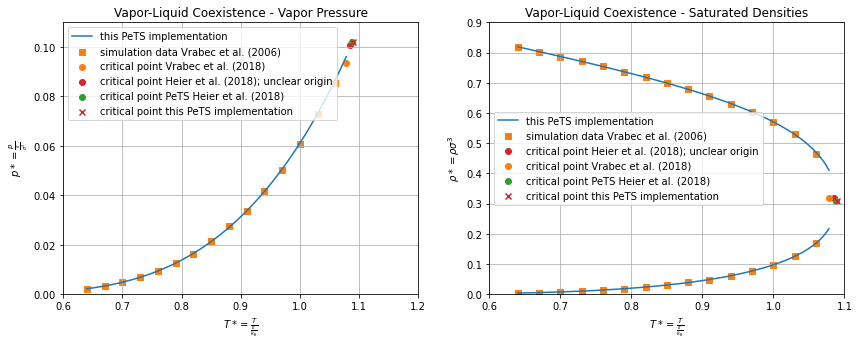

In [7]:
f, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].plot(temps, p_sat, color='tab:blue', label='this PeTS implementation')
ax[0].scatter(df['T*'], df['p*'], marker='s', color='tab:orange', label='simulation data Vrabec et al. (2006)')
ax[0].scatter(T_c_vrabec, p_c_vrabec, marker='o', color='tab:orange', label='critical point Vrabec et al. (2018)')
ax[0].scatter(T_c, p_c, marker='o', color='tab:red', label='critical point Heier et al. (2018); unclear origin')
ax[0].scatter(T_c_pets_heier, p_c_pets_heier, marker='o', color='tab:green', label='critical point PeTS Heier et al. (2018)')
ax[0].scatter(T_c_pets/epsilon_k, p_c_pets/(epsilon_k * KB / sigma**3), marker='x', color='tab:red', label='critical point this PeTS implementation')
ax[0].set_title('Vapor-Liquid Coexistence - Vapor Pressure')
ax[0].set_xlabel(r'$T* = \frac{T}{\frac{\epsilon}{k_\mathrm{B}}}$')
ax[0].set_ylabel(r'$p* = \frac{p}{\frac{\epsilon}{\sigma^3}}$')
ax[0].set_xlim(0.6, 1.2)
ax[0].set_ylim(0.0, 0.11)
ax[0].legend(loc='upper left')
ax[0].grid()

ax[1].plot(temps, rho_sat[:,0], color='tab:blue', label='this PeTS implementation')
ax[1].plot(temps, rho_sat[:,1], color='tab:blue')
ax[1].scatter(df['T*'], df['rho^L*'], marker='s', color='tab:orange', label='simulation data Vrabec et al. (2006)')
ax[1].scatter(df['T*'], df['rho^V*'], marker='s', color='tab:orange')
ax[1].scatter(T_c, rho_c, marker='o', color='tab:red', label='critical point Heier et al. (2018); unclear origin')
ax[1].scatter(T_c_vrabec, rho_c_vrabec, marker='o', color='tab:orange', label='critical point Vrabec et al. (2018)')
ax[1].scatter(T_c_pets_heier, rho_c_pets_heier, marker='o', color='tab:green', label='critical point PeTS Heier et al. (2018)')
ax[1].scatter(T_c_pets/epsilon_k, rho_c_pets*NAV*sigma**3, marker='x', color='tab:red', label='critical point this PeTS implementation')
ax[1].set_title('Vapor-Liquid Coexistence - Saturated Densities')
ax[1].set_xlabel(r'$T* = \frac{T}{\frac{\epsilon}{k_\mathrm{B}}}$')
ax[1].set_ylabel(r'$\rho* = \rho \sigma^3$')
ax[1].set_xlim(0.6, 1.1)
ax[1].set_ylim(0.0, 0.9)
ax[1].legend(loc='center left')
ax[1].grid()

## Binary Phase Diagram - Pressure-Composition of Pseudo Pure Fluid (Binary Mixture of the Same Component)

In [8]:
dia_p = PhaseDiagram.binary_vle(eos=pets, temperature_or_pressure=1*epsilon_k)

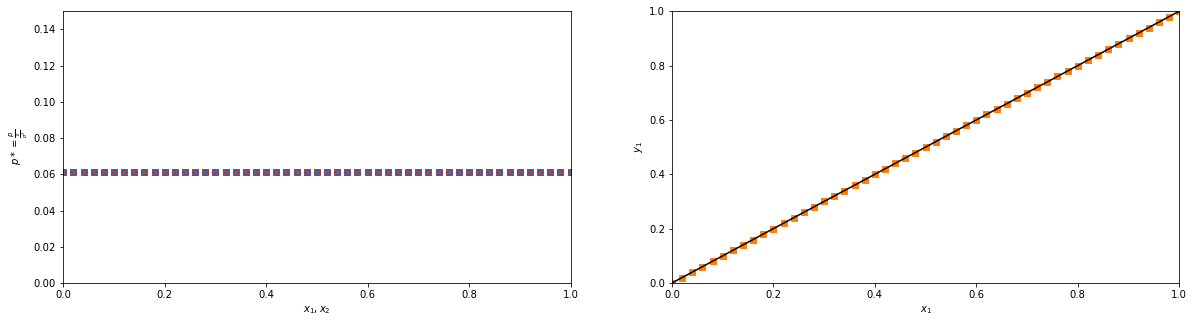

In [9]:
f, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].scatter(dia_p.liquid.molefracs[:,0], dia_p.liquid.pressure/(epsilon_k * KB / sigma**3), color='tab:red',  marker='s')
ax[0].scatter(dia_p.vapor.molefracs[:,0],  dia_p.vapor.pressure/(epsilon_k * KB / sigma**3), color='tab:blue', marker='x')
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 0.15)
ax[0].set_xlabel(r'$x_1, x_2$')
ax[0].set_ylabel(r'$p* = \frac{p}{\frac{\epsilon}{\sigma^3}}$')


ax[1].plot([0, 1], [0, 1], color='black')
ax[1].scatter(dia_p.liquid.molefracs[:,0], dia_p.vapor.molefracs[:,0], color='tab:orange',  marker='s')
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel(r'$x_1$')
ax[1].set_ylabel(r'$y_1$');